In [8]:

import copy
import time
import h5py 
import random
import logging
import argparse
import sys, os
import cupy as cp
import numpy  as np
from math import pi
from os.path import join
import matplotlib.pyplot as plt

from levelsetpy.utilities import *
from levelsetpy.visualization import *
from levelsetpy.grids import createGrid
from levelsetpy.dynamicalsystems import Bird, Flock 
from levelsetpy.initialconditions import shapeCylinder, shapeUnion
from levelsetpy.spatialderivative import upwindFirstENO2
from levelsetpy.explicitintegration.integration import odeCFL2, odeCFLset
from levelsetpy.explicitintegration.dissipation import artificia.dissipationGLF
from levelsetpy.explicitintegration.term import termRestrictUpdate, termLaxFriedrichs

import matplotlib as mpl
%matplotlib inline

### Running

+ Please consider running the example file: [Examples/murmurations.py](../Examples/murmurations.py) to collect all the BRTs per time steps for the safe motion problem.


In [9]:
def get_avoid_brt(flock, compute_mesh=True, color='crimson'):
	"""
		Get the avoid BRT for this flock. That is, every bird
		within a flock must avoid one another.

		Parameters:
		==========
		.flock: This flock of vehicles.
		.compute_mesh: compute mesh of local payoffs for each bird in this flock?
	"""
	for vehicle in flock.vehicles:
		# make the radius of the target setthe turn radius of this vehicle
		vehicle.payoff = shapeCylinder(flock.grid, 2, center=flock.update_state(vehicle.cur_state), \
										radius=vehicle.payoff_width)
	"""
		Now compute the overall payoff for the flock
	   	by taking a union of all the avoid sets.
	"""
	flock.payoff = shapeUnion([veh.payoff for veh in flock.vehicles])
	if compute_mesh:
		spacing=tuple(flock.grid.dx.flatten().tolist())
		flock.mesh_bundle = implicit_mesh(flock.payoff, 0, spacing,edge_color=None, face_color=color)

	return flock

def get_flock(gmin, gmax, num_points, num_agents, init_xyzs, label,\
				periodic_dims=2, reach_rad=.2, avoid_rad=.3,
				base_path='', save=True, color='blue'):
	"""
		Params
		======
		gmin: minimum bounds of the grid
		gmax: maximum bounds of the grid
		num_points: number of points on the grid
		num_agents: number of agents in this flock
		init_xyzs: initial positions of the individuals in this flock
		label: topological label of this flock among all flocks
		periodic_dims: periodic dimensions (usually theta: see)
		reach_rad: reach for external disturbance
		avoid_rad: avoid radius for topological interactions
	"""
	global u_bound, w_bound

	assert gmin.ndim==2, 'gmin must be of at least 2 dims'
	assert gmax.ndim==2, 'gmax must be of at least 2 dims'

	gmin = to_column_mat(gmin)
	gmax = to_column_mat(gmax)

	grid = createGrid(gmin, gmax, num_points, periodic_dims)

	vehicles = [Bird(grid, u_bound, w_bound, np.expand_dims(init_xyzs[i], 1), random.random(), \
					center=np.zeros((3,1)), neigh_rad=3, label=i+1, init_random=False) \
					for i in range(num_agents)]
	flock = Flock(grid, vehicles, label=label, reach_rad=.2, avoid_rad=.3)
	get_avoid_brt(flock, compute_mesh=True, color=color)

	return flock



In [14]:

start_time = time.time()
base_path = "/opt/LevPy/Murmurations/"
f = "murmurations_flock_00_04-28-23_18-13.hdf5"

murmur_files = sorted([m for m in os.listdir(base_path) if m.endswith('hdf5')])
print(murmur_files)
murmur_dict = {f"flock_{fname.split(sep='_')[2]}": {'spacing': None, 'time': []} for fname in murmur_files}


['murmurations_flock_00_04-14-23_13-11.hdf5', 'murmurations_flock_00_04-14-23_13-14.hdf5', 'murmurations_flock_00_04-14-23_13-16.hdf5', 'murmurations_flock_00_04-14-23_13-52.hdf5', 'murmurations_flock_00_04-14-23_13-54.hdf5', 'murmurations_flock_00_04-21-23_21-56.hdf5', 'murmurations_flock_00_04-21-23_21-57.hdf5', 'murmurations_flock_00_04-21-23_21-58.hdf5', 'murmurations_flock_00_04-21-23_21-59.hdf5', 'murmurations_flock_00_04-21-23_22-32.hdf5', 'murmurations_flock_00_04-23-23_13-54.hdf5', 'murmurations_flock_00_04-23-23_14-27.hdf5', 'murmurations_flock_00_04-23-23_14-28.hdf5', 'murmurations_flock_00_04-23-23_14-29.hdf5', 'murmurations_flock_00_04-23-23_14-53.hdf5', 'murmurations_flock_00_04-23-23_15-00.hdf5', 'murmurations_flock_00_04-23-23_15-02.hdf5', 'murmurations_flock_00_04-23-23_15-03.hdf5', 'murmurations_flock_00_04-23-23_15-10.hdf5', 'murmurations_flock_00_04-23-23_15-11.hdf5', 'murmurations_flock_00_04-23-23_15-14.hdf5', 'murmurations_flock_00_04-23-23_15-15.hdf5', 'murmurat

In [17]:

f = "murmurations_flock_00_04-28-23_18-13.hdf5"
flock_num = "00"
start_time = time.time()
with h5py.File(join(base_path, f), 'r+') as df:
    value_key = [k for k in df.keys()][0]
    keys = [key for key in df[value_key]]
    if 'spacing' in value_key:
        spacing = np.asarray(df["value/spacing"])
    else:
        gmin = np.asarray([[-1.5, -1.5, -np.pi]]).T
        gmax = np.asarray([[1.5, 1.5, np.pi] ]).T
        grid = createGrid(gmin, gmax, 101, 2)
        spacing = grid.dx.flatten()      
    murmur_dict[f'flock_{flock_num}']['spacing'] = tuple(spacing.tolist())

    idx = 0
    for key in keys[1:]:
        murmur_dict[f'flock_{flock_num}']['time'] += [key]
        murmur_dict[f'flock_{flock_num}'][f'{idx:0>3}'] = np.asarray(df[f"{value_key}/{key}"])
        idx += 1
end_time = time.time()
print(f"Time to load saved brats: {(end_time-start_time):.4f} secs.")

Time to load saved brats: 0.0052 secs.


In [22]:
murmur_dict[f'flock_{flock_num}']['00']

KeyError: '00'

In [24]:
def get_lims(verts):
    xlim = (verts[:, 0].min(), verts[:,0].max())
    ylim = (verts[:, 1].min(), verts[:,1].max())
    zlim = (verts[:, 2].min(), verts[:,2].max())

    return (xlim, ylim, zlim)

In [28]:
brt_time = np.hstack(([0], brt_time))
brt_time 

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [51]:
print([f"{x:.1f}" for x in brt_time])

['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
1.0


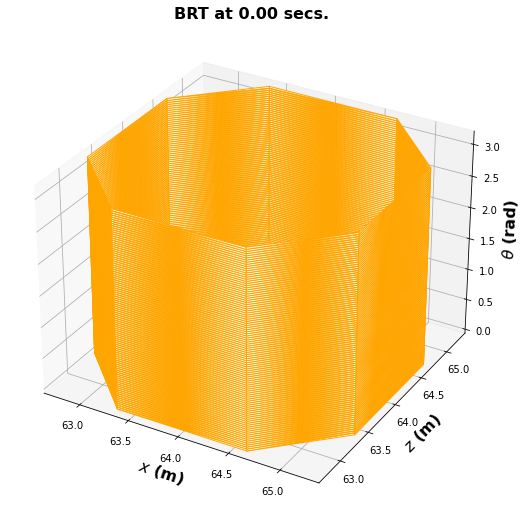

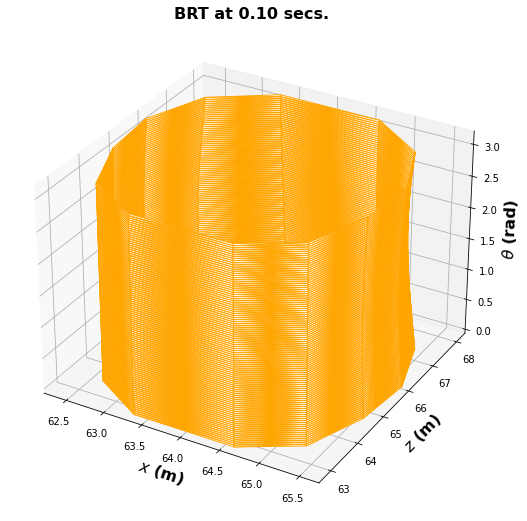

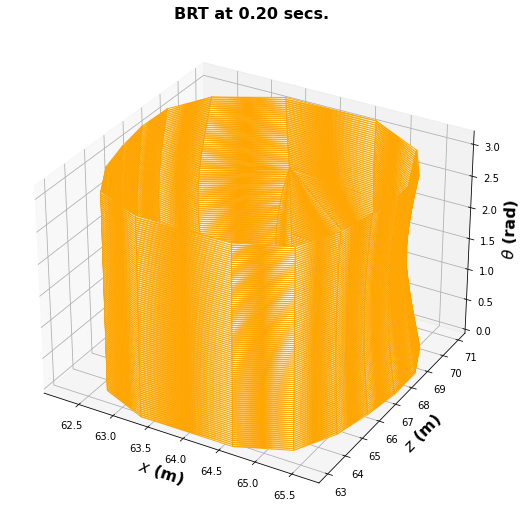

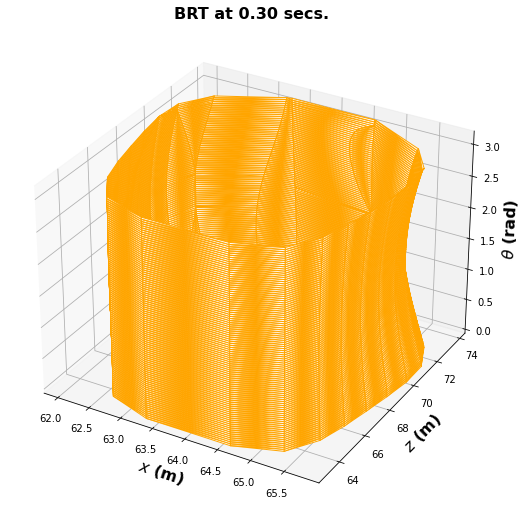

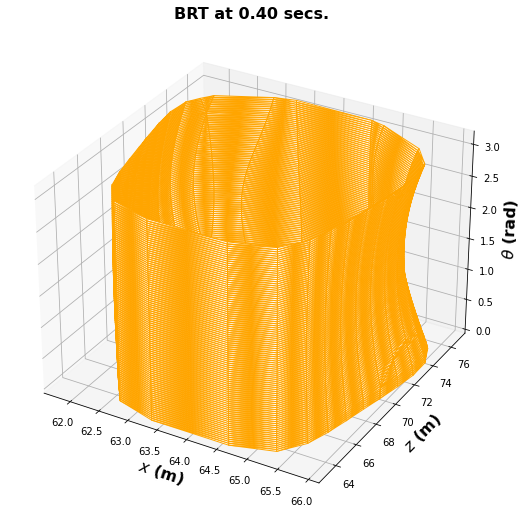

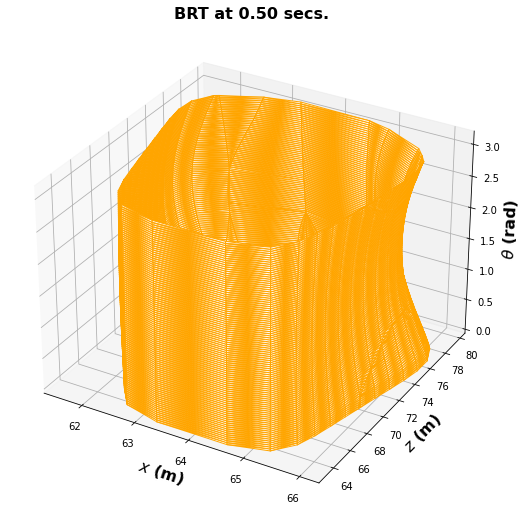

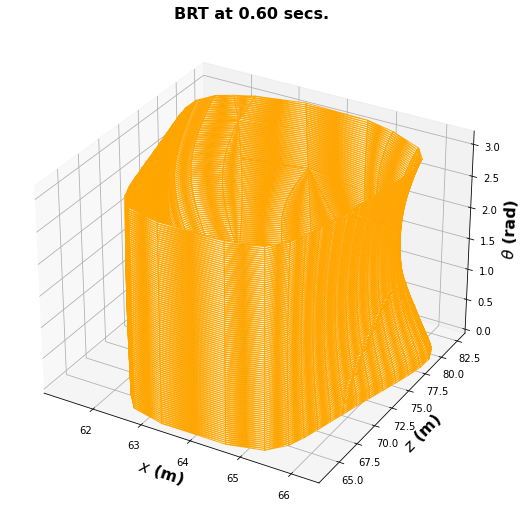

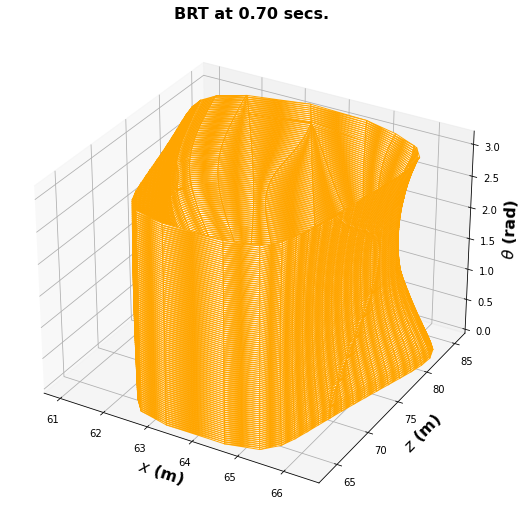

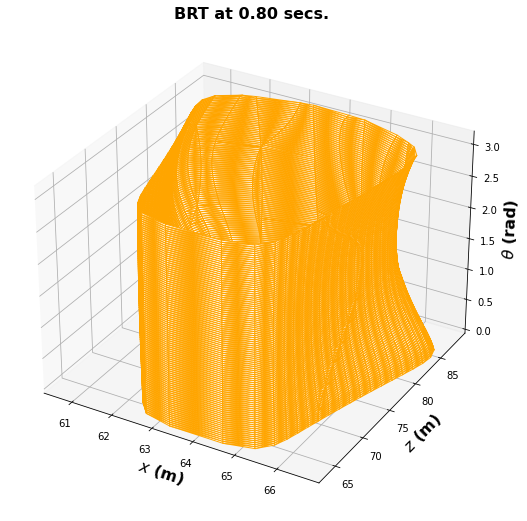

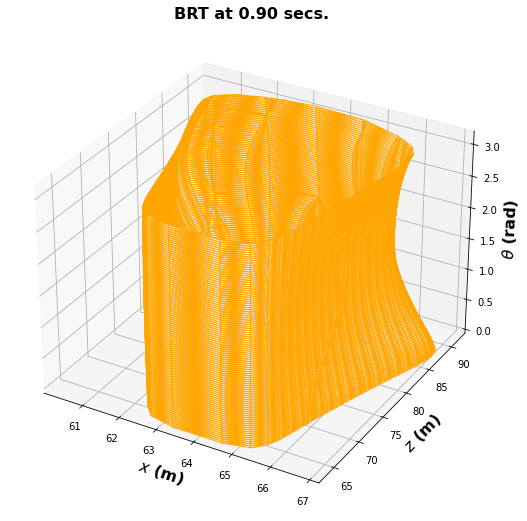

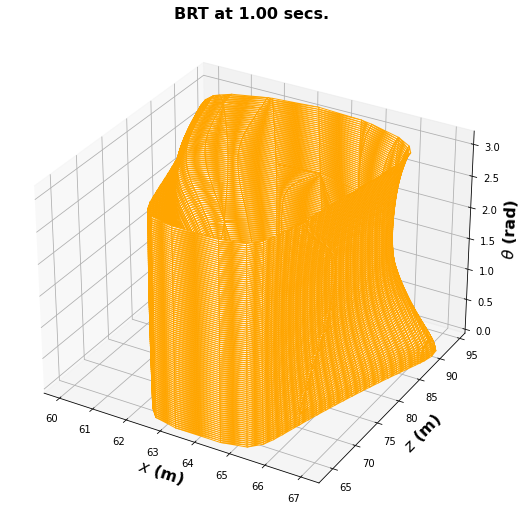

In [53]:
savepath= join("/opt/LevPy/Rockets")
import time 

for idx in range(brt.shape[0]):

    fig = plt.figure(figsize=(25,9))
    ax = fig.add_subplot(111, projection='3d')

    brt_this = brt[idx]
    time_this = brt_time[idx]

    
    mesh=implicit_mesh(brt_this, level=0, spacing=spacing,
                        edge_color='orange',  face_color='white')
    
    ax.add_collection3d(mesh.mesh)
    xlim, ylim, zlim = get_lims(mesh.verts)

    ax.set_xlim3d(*xlim)
    ax.set_ylim3d(*ylim)
    ax.set_zlim3d(*zlim)

    ax.set_xlabel(rf'$x$ (m)', fontdict=fontdict)
    ax.set_ylabel(rf'$z$ (m)', fontdict=fontdict)
    ax.set_zlabel(rf'$\theta$ (rad)',fontdict=fontdict)
    ax.set_title(f'BRT at {time_this:.2f} secs.', fontdict=fontdict)

    fig.canvas.draw()
    fig.canvas.flush_events()

    # plt.show()

    time.sleep(.1)

    print(time_this)
    fig = plt.gcf()
    fig.savefig(join(savepath, rf"rocket_{time_this:.2f}.jpg"), bbox_inches='tight',facecolor='None')
